In [36]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import geopandas as gpd
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from sklearn.linear_model import LinearRegression
import cv2
from rasterio import features
import rasterio.mask
import rasterio.merge

In [38]:
img_dir = "temp/dw_world_id3"
band_names = ['water', 'trees', 'grass', 'built']
img_paths = sorted(glob.glob(img_dir+"/*.tif"))
rasters = [rasterio.open(i) for i in img_paths]
first_raster = rasters[0]

In [39]:
first_img = first_raster.read()

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


### Forward fill all zeros with previous values

In [40]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    
def forward_fill_3d_array(img_array):
    fill_value = np.zeros((img_array.shape[1], img_array.shape[2]))
    result_array = img_array.copy()
    for i in range(result_array.shape[0]):
        na_mask = np.isnan(result_array[i])
        result_array[i][na_mask] = fill_value[na_mask]
        fill_value[~na_mask] = result_array[i][~na_mask]
    return result_array

def forward_fill_4d_array(img_array):
    fill_value = np.zeros((img_array.shape[1], img_array.shape[2], img_array.shape[3]))
    result_array = img_array.copy()
    for i in range(result_array.shape[0]):
        na_mask = np.isnan(result_array[i])
        result_array[i][na_mask] = fill_value[na_mask]
        fill_value[~na_mask] = result_array[i][~na_mask]
    return result_array

### Take mean of all images that belong to the same month and year

In [41]:
def get_time_from_filename(filename):
    date_time = os.path.basename(filename)[0:8]
    Y, M, D = int(date_time[0:4]), int(date_time[4:6]), int(date_time[6:8])
    return Y, M, D
def group_files_year_month(img_paths):
    Y_prev, M_prev, D_prev = get_time_from_filename(img_paths[0])
    img_labels = np.zeros(len(img_paths), dtype = int)
    curr_label = 0
    for i, img_path in enumerate(img_paths):
        Y, M, D = get_time_from_filename(img_path)
        if(Y == Y_prev and M == M_prev):
            img_labels[i] = curr_label
        else:
            curr_label+=1
            img_labels[i] = curr_label
        Y_prev, M_prev, D_prev = Y, M, D
    return img_labels


In [42]:
def img_mean_per_month_fun(img_array, img_grouped_label):
    result_array = np.zeros((1,img_array.shape[1], img_array.shape[2]))
    prev_label = img_grouped_label[0]
    label_start_idx = 0
    label_end_idx = 0
    for idx, curr_label in enumerate(img_grouped_label):
        if(curr_label!=prev_label):
            label_end_idx = idx
            mean_img = np.mean(img_array[label_start_idx:label_end_idx], axis = 0)
            result_array = np.append(result_array, mean_img[np.newaxis, ...], axis = 0)
            label_start_idx = idx
            prev_label = curr_label
    return result_array



## Analyize built area

### Get array of built probs

Also, fill all zeros with Nans

In [43]:
img_array = []
img_array = np.array([i.read(4) for i in rasters])
img_array_filtered = np.where(img_array==0, np.nan, img_array)
img_array.shape

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

(80, 903, 1052)

### Filtering pipeline

In [45]:
img_array_filled = forward_fill_3d_array(img_array_filtered)
img_grouped_label = group_files_year_month(img_paths)
img_mean_array = img_mean_per_month_fun(img_array_filled, img_grouped_label)

### Some smoothing functions

In [46]:
def exp_smoothing_1d(arr, alpha  = 0.01):
    b = [alpha]
    a = [1, -(1-alpha)]
    z2 = signal.lfilter(b, a, arr)
    return z2

def kernel_smoothing(img):
    result_array = np.zeros(img.shape)
    for i in range(img.shape[0]):
        smooth_image = cv2.GaussianBlur(img[i], (51, 51), 0)
        result_array[i] = smooth_image
    return result_array

In [47]:
img_smoothened = kernel_smoothing(img_array_filled)

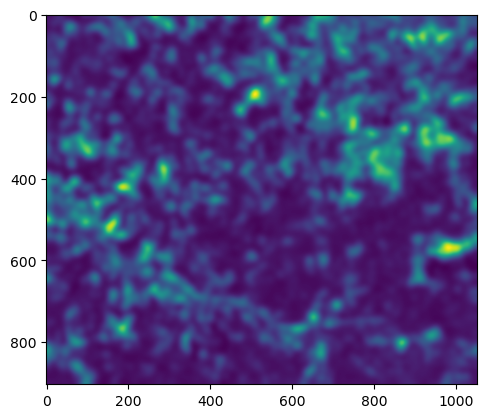

In [48]:
plt.imshow(img_smoothened[0])

## Generating heat map based on rise in slope

In [49]:
print(img_array_filled[:,666,900])

[0.04614472 0.03656629 0.03765978 0.08639488 0.03580004 0.03667725
 0.03186674 0.02728828 0.02728828 0.03102255 0.03694073 0.03694073
 0.03351644 0.0349848  0.0349848  0.0349848  0.0389619  0.0389619
 0.0389619  0.04900667 0.04900667 0.05272971 0.0498616  0.0498616
 0.0498616  0.06720101 0.05650922 0.05682887 0.029625   0.03088832
 0.02831098 0.03010492 0.02990404 0.02990404 0.02977752 0.02861991
 0.02861991 0.02861991 0.04362984 0.03428623 0.03428623 0.04016374
 0.04016374 0.04747845 0.04747845 0.0480855  0.0480855  0.0480855
 0.04766482 0.04766482 0.06481754 0.06108145 0.06032954 0.06032954
 0.06445289 0.05750746 0.03473409 0.03405494 0.02767276 0.02559141
 0.02634876 0.02606222 0.02588516 0.02588516 0.02720265 0.034558
 0.03286041 0.03168178 0.03168178 0.03441632 0.04132798 0.04132798
 0.04132798 0.04304536 0.04304536 0.04862235 0.04862235 0.04862235
 0.04862235 0.04862235]


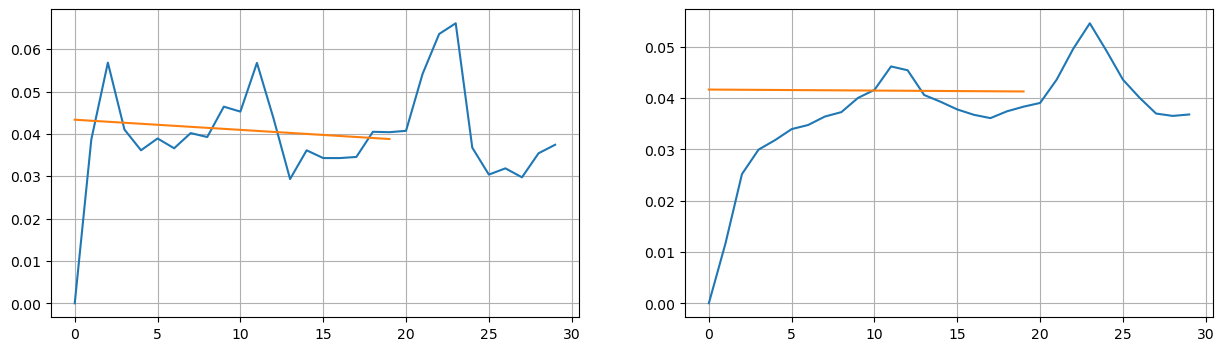

In [50]:
fig, axs = plt.subplots(1,2, figsize = (15,4))
data = img_mean_array[:,666,896]
# data = signal.medfilt(data, 5)
delay = 10
X = (np.arange(len(data[delay:]))/len(data[delay:])).reshape([-1,1])
axs[0].plot(data)
reg = LinearRegression().fit(X, data[delay:])
axs[0].plot(reg.coef_*X+reg.intercept_)
axs[0].grid()
axs[1].plot(exp_smoothing_1d(data, 0.3))
reg = LinearRegression().fit(X, exp_smoothing_1d(data, 0.3)[delay:])
# axs[1].plot(np.arange(len(data)), result[320,580]*np.arange(len(data))+intercepts[320,580])
axs[1].plot(reg.coef_*X+reg.intercept_)
axs[1].grid()

In [23]:
reg.coef_, reg.intercept_

(array([0.53850145]), 0.04229923412848696)

In [51]:
def img_slope_pipeline(image, alpha = 0.3, delay = 10, time_period = -1, return_intercept = False):
    img_shp = image.shape
    result = np.zeros((img_shp[1], img_shp[2]))
    intercepts = np.zeros((img_shp[1], img_shp[2]))
    if(time_period>-1):
        time_period = delay+time_period
    for y_idx in range(img_shp[1]):
        for x_idx in range(img_shp[2]):
            data = image[:,y_idx, x_idx]
            # data_smoothened = data[delay:]
            data_smoothened = signal.medfilt(data, 5)
            data_smoothened = exp_smoothing_1d(data_smoothened, alpha)[delay:time_period]
            X = np.arange(len(data_smoothened)).reshape([-1,1])
            X = X/len(X)
            reg = LinearRegression().fit(X, data_smoothened)
            result[y_idx, x_idx] = reg.coef_
            intercepts[y_idx, x_idx] = reg.intercept_
    if return_intercept:  return result, intercepts
    else: return result



In [54]:
img_mean_array.shape

(30, 903, 1052)

In [55]:
result, intercepts = img_slope_pipeline(img_mean_array, return_intercept=True, delay = 10, time_period=14 )
result.max(), result.min()

(0.4013469035614423, -0.3843313819222026)

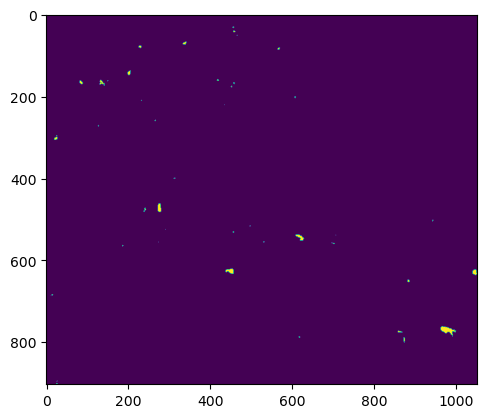

In [221]:
out_meta = first_raster.meta
out_meta.update({"count":1, 'dtype':'uint8'})
thresholded_buildings = result>0.3
with rasterio.open('temp/slope_thresh.tif', 'w', **out_meta) as dst:
    dst.write(thresholded_buildings[np.newaxis, ...])
out_meta.update({'dtype':'float64'})
with rasterio.open('temp/slope_val.tif', 'w', **out_meta) as dst:
    dst.write(result[np.newaxis, ...])
result_raster = rasterio.open('temp/slope_val.tif')
plt.imshow(thresholded_buildings)

### Results validation

In [136]:
label_path = "/Users/pranavprakash/Library/CloudStorage/OneDrive-AiDashInc/Documents/data/change_detection_dataset/dominion_labeled_2022/labels/ID_3_20220401"
df_label = gpd.read_file(label_path)
df_label = df_label.to_crs(str(first_raster.crs))
df_label.Label.unique()

array(['Clearing of timberland', 'Buildings', 'Construction of new roads',
       'Removal of structures', 'Construction of swimming pool',
       'Clearing for foundations', 'Others', 'Under contruction Sites',
       'Water bodies'], dtype=object)

Under construction sites:

For areas above 25m by 25m: 70 percent overlap


In [137]:
df_construction = df_label[df_label.Label.isin(['Under contruction Sites','Clearing for foundations'])]
len(df_construction)

84

In [138]:
from shapely.ops import transform as tfr
from functools import partial
from pyproj import Proj, transform,Transformer
from shapely.geometry import LineString, Point,mapping,Polygon,shape
from shapely.ops import unary_union
def fetch_length(geom):
    minx, miny, maxx, maxy = geom.bounds
    #3857
    proj_3857 = Proj("+proj=aea +lat_1={0} +lat_1={1} ""+lat_0={2} +lon_0={3}".format(miny,maxy,(miny + maxy) / 2.0,(minx + maxx) / 2.0))
    proj_4326 = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    s = shape(geom)
    proj = partial(transform,proj_4326,proj_3857)
    projected_area = tfr(proj, s).area
    return projected_area

In [222]:
def mask_to_shp(masked_raster):
    shapes = features.shapes(masked_raster.astype(np.uint8), transform=first_raster.transform)
    geom = []
    values = []
    for g, v in shapes:
        values.append(v)
        geom.append(g)
    predicted_array = np.array(values) == 1.0
    geom = np.array(geom)[predicted_array]
    geom_poly = list(map(lambda x: Polygon(x['coordinates'][0]).convex_hull, geom))
    labels = ["Under construction sites"]*len(geom_poly)
    df_pred = gpd.GeoDataFrame({"Label": labels, "geometry": geom_poly})
    return df_pred, geom_poly
df_pred, geom_poly = mask_to_shp(thresholded_buildings)
df_pred.to_file("temp/under_construction_pred/geodata_firstYear.shp")

In [140]:
geom_unary = unary_union(geom_poly)
df_construction.intersects(geom_unary).sum()

35

In [141]:
def get_iou_matrix(gt, pred):
    iou_matrix = np.zeros((len(gt), len(pred)))
    for idx_gt, poly_gt in enumerate(gt):
        for idx_pred, pred_gt in enumerate(pred):
            polygon_intersection = poly_gt.intersection(pred_gt).area
            polygon_union = poly_gt.union(pred_gt).area
            IOU = polygon_intersection / polygon_union 
            iou_matrix[idx_gt, idx_pred] = IOU
    return iou_matrix
iou_matrix = get_iou_matrix(df_construction.geometry.values, geom_poly)
iou_max = np.max(iou_matrix, axis = 1).tolist()
assert len(iou_max) == len(df_construction), "Length not equal"
df_construction['iou'] = iou_max
df_construction['area'] = df_construction.area

/Users/pranavprakash/miniforge3/envs/aidash/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/pranavprakash/miniforge3/envs/aidash/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [142]:
df_construction.Label.unique()

array(['Clearing for foundations', 'Under contruction Sites'],
      dtype=object)

In [189]:
clearing_foundation_over_3000 = df_construction[((df_construction.Label == 'Clearing for foundations')) & (df_construction['area']>3000)]
print(len(clearing_foundation_over_3000), len(clearing_foundation_over_3000[clearing_foundation_over_3000.iou>0.1]))

45 18


In [190]:
clearing_foundation_over_3000

,Label,TimeLabel,geometry,iou,area
164,Clearing for foundations,Old,"POLYGON ((578041.749 3962884.067, 578041.696 3...",0.000000,3136.289657
165,Clearing for foundations,New,"POLYGON ((577996.002 3962881.017, 577998.833 3...",0.509324,12532.484168
261,Clearing for foundations,New,"POLYGON ((578364.523 3965083.525, 578372.262 3...",0.000000,4610.867056
317,Clearing for foundations,New,"POLYGON ((582432.175 3962556.064, 582434.804 3...",0.000000,4411.006852
386,Clearing for foundations,New,"POLYGON ((582702.993 3963366.433, 582715.246 3...",0.406548,19460.129629
409,Clearing for foundations,None,"POLYGON ((582219.425 3964313.848, 582219.822 3...",0.440515,4141.955561
491,Clearing for foundations,Old,"POLYGON ((582713.677 3964002.289, 582725.063 3...",0.000000,8539.261524
646,Clearing for foundations,Old,"POLYGON ((583046.516 3964260.892, 583029.371 3...",0.571988,65726.743047
819,Clearing for foundations,New,"POLYGON ((582534.489 3967035.099, 582552.745 3...",0.794929,27818.333550
849,Clearing for foundations,New,"POLYGON ((583669.560 3964575.700, 583667.964 3...",0.353125,4669.534697


In [164]:
print(len(df_construction[((df_construction.Label == 'Clearing for foundations')) & (df_construction.iou>0.1)]))
print(len(df_construction[(df_construction.Label == 'Under contruction Sites')]), len(df_construction[((df_construction.Label == 'Under contruction Sites')) & (df_construction.iou>0.1)]))
print(len(df_construction[(df_construction.Label == 'Clearing for foundations')]), len(df_construction[((df_construction.Label == 'Clearing for foundations')) & (df_construction.iou>0.1)]))

26
9 4
75 26


In [128]:
selected_shp_file = "/Users/pranavprakash/Library/CloudStorage/OneDrive-AiDashInc/Documents/data/change_detection_dataset/dominion_labeled_2022/labels/selected_labels/selected.shp"
selected_shp = gpd.read_file(selected_shp_file)
selected_shp = selected_shp.to_crs(str(result_raster.crs))
selected_img = rasterio.mask.raster_geometry_mask(result_raster,selected_shp.geometry.values, invert = True)
# selected_img, _ = rasterio.mask.mask(result_raster,selected_shp.geometry.values)

In [130]:
np.where(selected_img[0]>0)[0], np.where(selected_img[0]>0)[1]

(array([664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 665, 666,
        666, 666, 666, 666, 666, 666, 666, 666, 667, 667, 667, 667, 667,
        667, 667, 667, 667, 668, 668, 668, 668, 668, 668, 668, 668, 668,
        669, 669, 669, 669, 669, 669, 669, 669, 669, 670, 670, 670, 670,
        670, 670, 670, 670, 670, 671, 671, 671, 671, 671, 671, 671, 671,
        671, 672, 672, 672, 672, 672, 672, 672, 672, 672]),
 896.0)

## Clearing for foundation

In [152]:
img_array = []
img_array = np.array([i.read(3) for i in rasters])
img_array_filtered = np.where(img_array==0, np.nan, img_array)
img_array_filled = forward_fill_3d_array(img_array_filtered)
img_grouped_label = group_files_year_month(img_paths)
img_mean_array = img_mean_per_month_fun(img_array_filled, img_grouped_label)
img_array.shape

(170, 903, 1052)

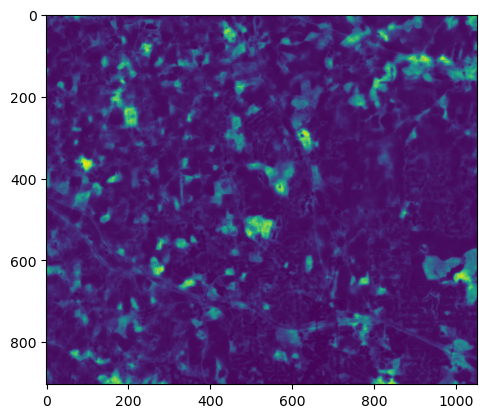

In [153]:
plt.imshow(img_mean_array[20])

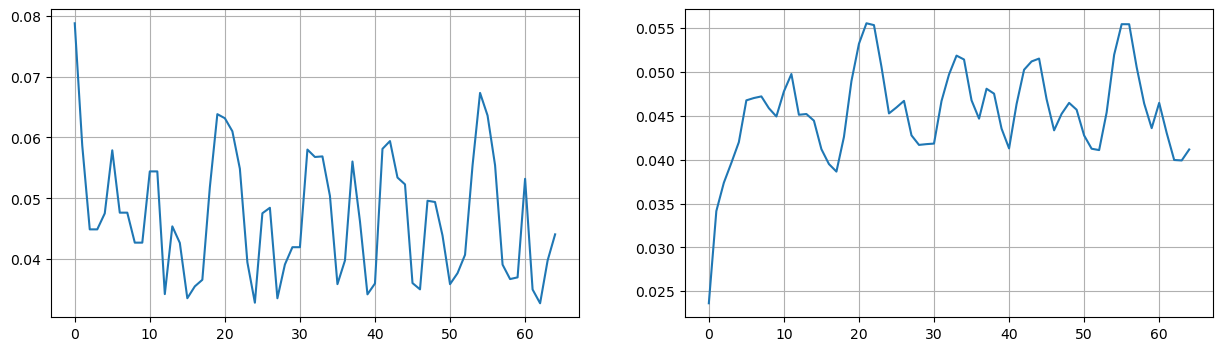

In [154]:
fig, axs = plt.subplots(1,2, figsize = (15,4))
data = img_mean_array[1:,701,874]
# data = signal.medfilt(data, 5)
axs[0].plot(data)
axs[0].grid()
axs[1].plot(exp_smoothing_1d(data, 0.3))
axs[1].grid()

In [155]:
result_foundation = img_slope_pipeline(img_mean_array)
print(result_foundation.max(), result_foundation.min())

0.4298156365116016 -0.5217164745122662


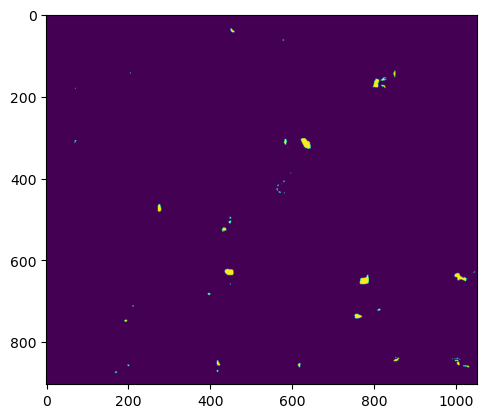

In [157]:
thresholded_result_foundation = result_foundation<-0.2
plt.imshow(thresholded_result_foundation)
out_meta = first_raster.meta
out_meta.update({"count":1, 'dtype':'uint8'})
# out_meta.update({"count":1})
with rasterio.open('temp/foundation_slope_thresh.tif', 'w', **out_meta) as dst:
    dst.write(thresholded_result_foundation[np.newaxis, ...])

In [180]:
thresholded_result_foundation_df, _ = mask_to_shp(thresholded_result_foundation)
thresholded_result_foundation_df.to_file("temp/clearing_foundation_pred")

## Analyze Clearing of timberland

In [158]:
img_array = []
img_array = np.array([i.read(2) for i in rasters])
img_array_filtered = np.where(img_array==0, np.nan, img_array)
img_array.shape

(170, 903, 1052)

In [159]:
img_array_filled = forward_fill_3d_array(img_array_filtered)
img_grouped_label = group_files_year_month(img_paths)
img_mean_array = img_mean_per_month_fun(img_array_filled, img_grouped_label)

In [673]:
img_save = (img_mean_array[20]*255).astype(np.uint8)
from skimage.io import imsave
imsave("tree_prob.png", img_save)

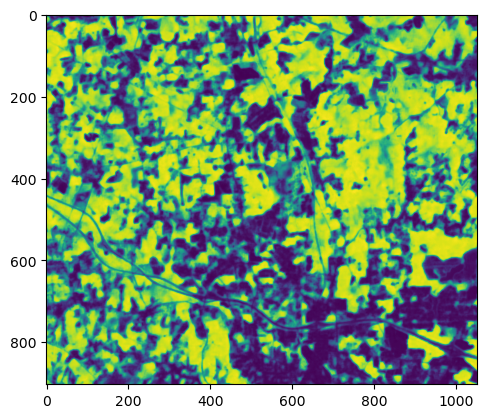

In [653]:
plt.imshow(img_mean_array[20])

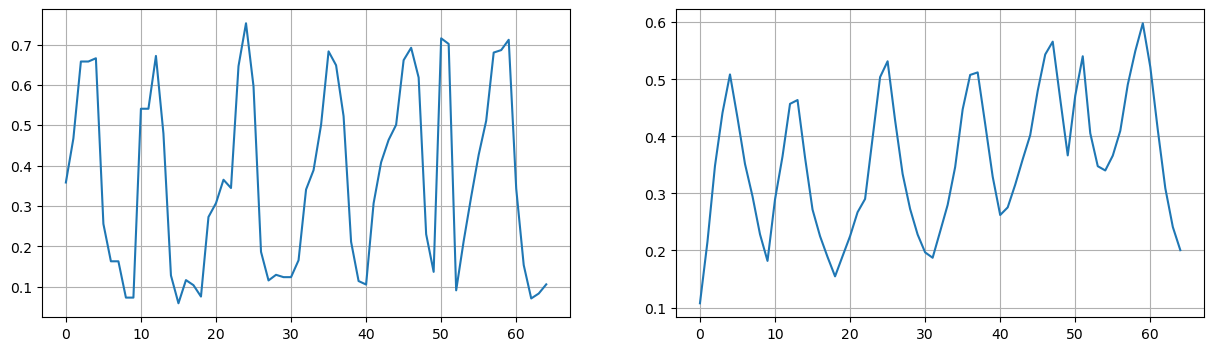

In [680]:
fig, axs = plt.subplots(1,2, figsize = (15,4))
data = img_mean_array[1:,701,874]
# data = signal.medfilt(data, 5)
axs[0].plot(data)
axs[0].grid()
axs[1].plot(exp_smoothing_1d(data, 0.3))
axs[1].grid()

In [174]:
result_trees = img_slope_pipeline(img_mean_array, delay = 10)
mean_before = np.median(img_mean_array[10:20], axis = 0)
mean_after = np.median(img_mean_array[-10:], axis = 0)
deforrestation_mean_based = (mean_before>0.5) & (mean_after<0.5)
result_trees.max(), result_trees.min()

(0.7497776532171444, -0.9121451891043871)

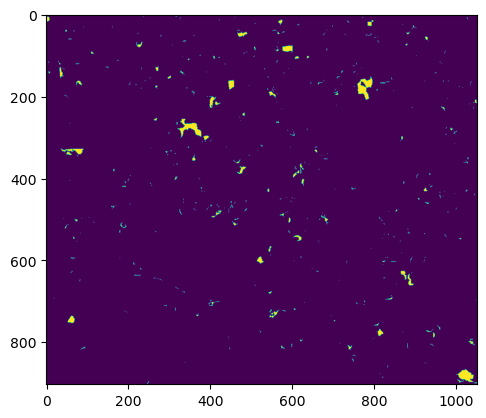

In [175]:
plt.imshow(deforrestation_mean_based)

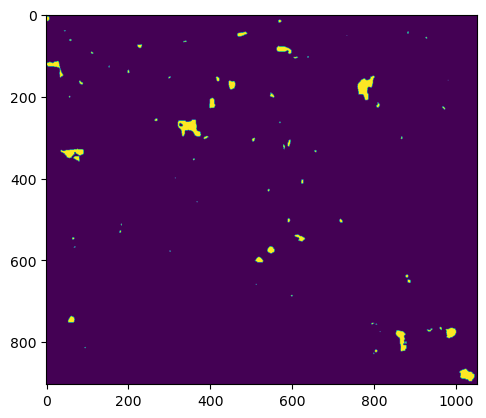

In [178]:
thresholded_result_trees = result_trees<-0.3
plt.imshow(thresholded_result_trees)
out_meta = first_raster.meta
out_meta.update({"count":1, 'dtype':'uint8'})
# out_meta.update({"count":1})
with rasterio.open('temp/trees_slope_thresh.tif', 'w', **out_meta) as dst:
    dst.write(thresholded_result_trees[np.newaxis, ...])

In [179]:
thresholded_result_trees_df, _ = mask_to_shp(thresholded_result_trees)
thresholded_result_trees_df.to_file("temp/clearing_trees_pred")

### Results

## Based on difference of old and past images

In [249]:
n_samples = 50
img_before = img_array_filled[0:n_samples,...]
img_after = img_array_filled[-n_samples:,...]

In [250]:
mean_probs = np.nanmedian(img_before, axis = 0)
max_probs = np.nanmax(img_before, axis = 0)
min_probs = np.nanmin(img_before, axis = 0)
var_probs = np.nanstd(img_before, axis = 0)
mean_probs.shape

(903, 1052)

In [251]:
mean_probs_after = np.nanmedian(img_after, axis = 0)
max_probs_after = np.nanmax(img_after, axis = 0)
min_probs_after = np.nanmin(img_after, axis = 0)
var_probs_after = np.nanstd(img_after, axis = 0)
mean_probs.shape

(903, 1052)

In [167]:
z_score = (img_array-mean_probs[np.newaxis, ...])/(var_probs[np.newaxis, ...])
z_score.shape

(170, 903, 1052)

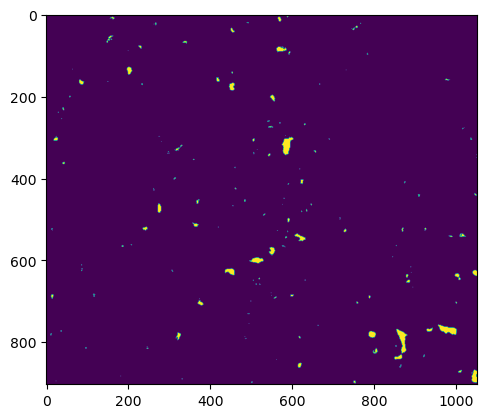

In [290]:
diff_probs = np.abs(mean_probs_after - mean_probs)
plt.imshow((diff_probs)>0.3)
plt.imsave("test.png", (diff_probs)>0.3)

In [66]:
var_probs[np.newaxis, ...].shape

(1, 903, 1052)

In [254]:
out_meta = first_raster.meta
out_meta.update({"count":1, 'dtype':'uint8'})
with rasterio.open('temp/my_image.tif', 'w', **out_meta) as dst:
    dst.write(diff_probs[np.newaxis, ...]>0.3)

## Direction of change

## Analysis of monthly downloaded tiff files

In [1]:
import os
import glob
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

In [33]:
source_dir  = "/Users/pranavprakash/Documents/aidash/change_detection/temp/ameren_dw_geom1"
tile_dir = "/Users/pranavprakash/Documents/aidash/change_detection/temp/ameren_dw_geom1/2021/01"
file_list = glob.glob(source_dir + "/**/*.tif", recursive=True)
unique_tiles = os.listdir(tile_dir+"/")

In [32]:
focus_tile = str(unique_tiles[0])
relevant_file_list = [i for i in file_list if focus_tile in i]

In [11]:
rasters = [rio.open(i) for i in relevant_file_list]
img_array = []
img_array = np.array([i.read() for i in rasters])
img_array_filtered = np.where(~np.any(img_array, axis =1)[:,np.newaxis,:,:], np.nan, img_array)
img_array = forward_fill_4d_array(img_array_filtered)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

(25, 9, 131, 131)

In [12]:
img_array.shape

(25, 9, 131, 131)

In [34]:
def img_slope_pipeline(image, alpha = 0.3, delay = 10, time_period = -1, return_intercept = False):
    img_shp = image.shape
    result = np.zeros((img_shp[1], img_shp[2]))
    intercepts = np.zeros((img_shp[1], img_shp[2]))
    if(time_period>-1):
        time_period = delay+time_period
    for y_idx in range(img_shp[1]):
        for x_idx in range(img_shp[2]):
            data = image[:,y_idx, x_idx]
            data_smoothened = data
            # data_smoothened = data[delay:]
            # data_smoothened = signal.medfilt(data, 5)
            # data_smoothened = exp_smoothing_1d(data_smoothened, alpha)[delay:time_period]
            X = np.arange(len(data_smoothened)).reshape([-1,1])
            X = X/len(X)
            reg = LinearRegression().fit(X, data_smoothened)
            result[y_idx, x_idx] = reg.coef_
            intercepts[y_idx, x_idx] = reg.intercept_
    if return_intercept:  return result, intercepts
    else: return result

In [35]:
dest_dir = "/Users/pranavprakash/Documents/aidash/change_detection/temp/test_ge_results"
for focus_tile in unique_tiles:
    relevant_file_list = [i for i in file_list if focus_tile in i]
    rasters = [rio.open(i) for i in relevant_file_list]
    img_array = []
    img_array = np.array([i.read() for i in rasters])
    img_array_filtered = np.where(~np.any(img_array, axis =1)[:,np.newaxis,:,:], np.nan, img_array)
    img_array = forward_fill_4d_array(img_array_filtered)
    img_solpes = img_slope_pipeline(img_array[:,0,...])
    img_meta = rasters[0].meta
    img_meta.update({'count':1})
    dest_file_name = dest_dir+"/"+focus_tile+"_img.tif"
    with rasterio.open(dest_file_name, 'w', **img_meta) as dest:
        dest.write(img_solpes[np.newaxis,...])
result_tiles = glob.glob(dest_dir+"/*.tif")
rasterio.merge.merge(result_tiles, dst_path = dest_dir+"/merged.tif")

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 